# Practicing a Histogram Orientated Gradient (HOG)

In [1]:
import cv2
import open3d as o3d
import numpy as np 
import matplotlib.pyplot as plt

from skimage import io
from skimage import color
from skimage.transform import resize
import math
from skimage.feature import hog

%load_ext autoreload
%autoreload 2
%autosave 180

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


# Step 1: Preprocessing 

In [2]:
# Load the image
im = cv2.imread('/home/daniel-choate/ASAR/s2/TerrainNav/Match_Demos/bolt_orig.png')

print(im.shape)
# Specify the desired dimensions to crop specific pictures 
width_s = 350
width_e = width_s + 200 # desired width in pixels
height_s = 50
height_e = height_s + 400  # desired height in pixels

print('The selected pixel ratio is', width_e-width_s, 'x', height_e-height_s)

# Crop the image 
im_crop = im[height_s:height_e, width_s:width_e] #, height_s:height_e]
# print(im_crop.size)
print(im_crop.shape)

# RESIZE the image to 64x128
width_n = 64
height_n = 128
new_dim = (width_n, height_n)
im_fin = cv2.resize(im_crop, new_dim)
print(im_fin.shape)

# Save the resized image
# cv2.imwrite('/home/daniel-choate/ASAR/s2/TerrainNav/Match_Demos/bolt_resized.png', im_fin)

# Optionally, display the resized image
# Can do with opencv, don't need open3d
cv2.imshow('Resized Image', im_fin)
cv2.waitKey(0)
cv2.destroyAllWindows()


(503, 793, 3)
The selected pixel ratio is 200 x 400
(400, 200, 3)
(128, 64, 3)


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""


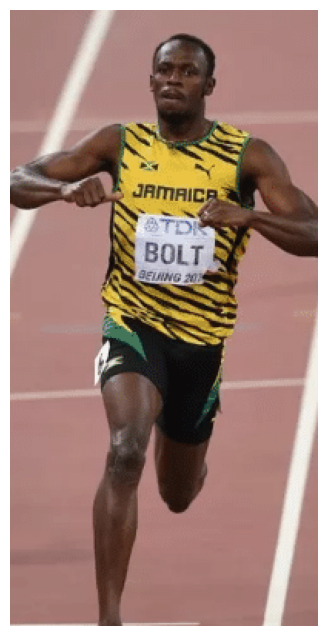

In [3]:
# Change coloring when moving from opencv to matplotlib 
plt.figure(figsize=(15, 8))
image_rgb = cv2.cvtColor(im_crop, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis("off")
plt.show()

# Step 2: Calculate Gradient Images 

In [4]:
# Choose specific image 
image_fn = "/home/daniel-choate/ASAR/s2/TerrainNav/Match_Demos/bolt_cropped.png"
# image_fn = "/home/daniel-choate/ASAR/s2/TerrainNav/Match_Demos/bolt_resized.png"
im = cv2.imread(image_fn)
im = np.float32(im) / 255.0
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # Open CV uses BGR??
# print(im.shape)

# Calculate gradient
gx = cv2.Sobel(im, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(im, cv2.CV_32F, 0, 1, ksize=1)
print(gx.shape)

# print("\n Gradients in the x-direction \n", gx)
# print("\n Gradients in the y-direction \n", gy)

# Calculate gradient magnitude and direction ( in degrees )
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
print(mag.shape)
# print("\n Angles \n", angle)

(400, 200, 3)
(400, 200, 3)


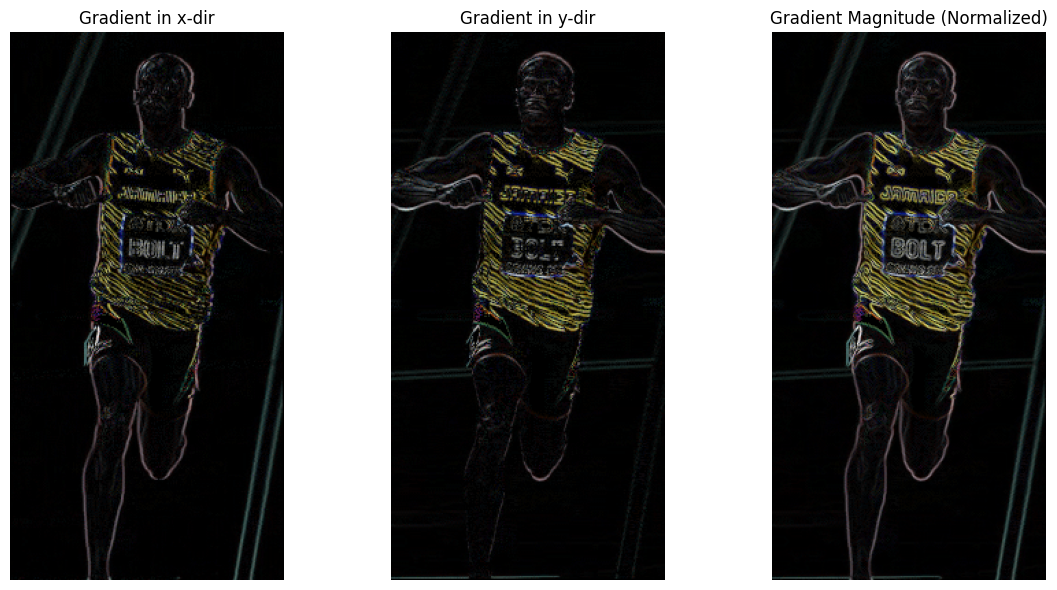

In [5]:
# Plot image gradients 

# Plot gradient magnitude in x
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(np.abs(gx))#, cmap='gray')
plt.title('Gradient in x-dir')
plt.axis('off')

# Plot gradient magnitude in y
# plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 2)
plt.imshow(np.abs(gy))#, cmap="gray")
plt.title('Gradient in y-dir')
plt.axis("off")

# Plot gradient magnitude normalized
# plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 3)
magnitude_normalized = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
plt.imshow(magnitude_normalized)#, cmap='gray')
# plt.imshow(mag, cmap='gray')
plt.title('Gradient Magnitude (Normalized)')
plt.axis('off')

plt.tight_layout()
plt.show()

# print("OG MAG \n", mag)
# print("\n DIF MAG \n", magnitude_normalized)

# Step 3: Calculate Histogram of Gradients

In [11]:
# First: for color data ...
# Magnitude: max magnitude from 3-color channel data 
# Angle: angle associated with that magnitude 
print("\n Mags \n", mag)
print("\n Angles \n", angle)
mag_max_ind = np.argmax(mag, axis=2)
mag_simp = np.max(mag, axis=2)
mag_simp = np.expand_dims(mag_simp, axis=2)  # Expand the dimensions to (400, 200, 1)
# ang_simp = angle[:,:,mag_max_ind]
ang_simp = np.take_along_axis(angle, mag_max_ind[..., np.newaxis], axis=2)
print("\n Maximum magnitude for color channels \n", mag_simp)
print("\n Angle for max mangnitude \n", ang_simp)


 Mags 
 [[[0.         0.         0.        ]
  [0.00784314 0.         0.00784314]
  [0.00784314 0.         0.00784314]
  ...
  [0.         0.         0.        ]
  [0.01568627 0.         0.00784314]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.00392157 0.         0.01568627]
  [0.         0.         0.        ]
  ...
  [0.01960784 0.01176473 0.00876889]
  [0.01960784 0.01413944 0.00876892]
  [0.00392157 0.01176473 0.01176471]]

 [[0.         0.         0.        ]
  [0.00784314 0.         0.00784314]
  [0.00784314 0.         0.00784314]
  ...
  [0.00392157 0.01176473 0.01176471]
  [0.01240109 0.01663785 0.01240109]
  [0.01568627 0.00784314 0.00784317]]

 ...

 [[0.01568627 0.04705885 0.04705882]
  [0.00392157 0.0316167  0.0316167 ]
  [0.01240109 0.06286755 0.06274512]
  ...
  [0.         0.         0.        ]
  [0.01568627 0.         0.00784314]
  [0.         0.         0.        ]]

 [[0.19999999 0.29411766 0.2784314 ]
  [0.21190989 0.303206   0.2

In [13]:
# Seperate the grid into 8x8 cells

# Assume grid is of size (height, width)
height, width = mag.shape[:2]
print(height)
print(width)
cell_size = 8

# Ensure the height and width are divisible by 8
assert height % cell_size == 0 and width % cell_size == 0, "Height and width should be divisible by 8."

# Splitting the grid into 8x8 cells
cells = grid.reshape(height // cell_size, cell_size, width // cell_size, cell_size).swapaxes(1, 2)

# Now `cells` is of shape (num_cells_y, num_cells_x, 8, 8)


400
200


NameError: name 'grid' is not defined